## Script's Goals

This script is used to pre-process the transcriptomic data. The genes across each dataset will be align to enable a consistent comparison. The number of genes that we will put in the machine learning model will be reduce to avoid the overfitting and to simplify the model. Normalization will be applied to scale data across different datasets and harmonize their distributions. Additionally, batch correction will be performed to account for differences between health statuses.

 ## Import packages

In [34]:
import pandas as pd
import anndata as ad
import scanpy as sc
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns

## Define Function

In [35]:
def charge_tsv(path):
    # function to load a tsv_file in a pandas table
    df = pd.read_csv(path, sep='\t', header=0, index_col=0)
    return df

In [36]:
def construct_ad(dico):
    # function to create an anndata object containing all the dataset and the batch and the role (train/test) in obs.
    
    adata_list= []
    
    # Iterate over the dictionary and create AnnData objects
    for name, df in filtered_datasets.items():
        # Extract batch and role from the name
        batch = name
        role = name.split('_')[1]
        status = name.split('_')[0]

        # Create an AnnData object
        adata = ad.AnnData(df)

        # Add 'batch' and 'role' columns to the obs dataframe
        adata.obs['batch'] = batch
        adata.obs['role'] = role
        adata.obs['status'] = status

        # Append the AnnData object to the list
        adata_list.append(adata)

    # Combine all AnnData objects into one
    combined_adata = ad.concat(adata_list)
    return combined_adata

In [38]:
def preprocess(adata, batch_correction, N_GENES):

    # Step 1: Normalize for library size per sample
    sc.pp.normalize_total(adata, target_sum=1e4)

    # Step 2: Log1p transformation
    sc.pp.log1p(adata)

    # Step 3: Select highly variable genes accounting for batch effect
    sc.pp.highly_variable_genes(adata, n_top_genes=N_GENES, batch_key='batch')
    sc.pl.highly_variable_genes(adata)

    # Step 4: Keep only the highly variable genes
    adata = adata[:, adata.var['highly_variable']]

    # Optionnal Step 5: Batch correction
    if batch_correction == True:
        sce.pp.combat(adata, key='batch')  # Corrects batch effects using Combat
    return adata

## Load the data

In [39]:
healthy_train = charge_tsv("/home/mc202900/datasets_scienta/healthy_train_data.tsv")
healthy_test = charge_tsv("/home/mc202900/datasets_scienta/healthy_test_data.tsv")
ra_train = charge_tsv("/home/mc202900/datasets_scienta/ra_train_data.tsv")
ra_test = charge_tsv("/home/mc202900/datasets_scienta/ra_test_data.tsv")
sle_train = charge_tsv("/home/mc202900/datasets_scienta/sle_train_data.tsv")
sle_test = charge_tsv("/home/mc202900/datasets_scienta/sle_test_data.tsv")

In [40]:
datasets = {
    "healthy_train": healthy_train,
    "healthy_test": healthy_test,
    "ra_train": ra_train,
    "ra_test": ra_test,
    "sle_train" : sle_train,
    "sle_test" : sle_test
}

## Select only the genes shared by all dataframes

In [41]:
# 1. Find the common columns across all DataFrames
common_columns = set(datasets['healthy_train'].columns)
for df in datasets.values():
    common_columns.intersection_update(df.columns)

# 2. Create a new dictionary with filtered DataFrames, keeping only the common columns
filtered_datasets = {name: df[list(common_columns)] for name, df in datasets.items()}

In [42]:
for name, df in filtered_datasets.items():
    row, col = df.shape
    print(f'The dataset {name} has {row} rows and {col} columns')

The dataset healthy_train has 302 rows and 24403 columns
The dataset healthy_test has 100 rows and 24403 columns
The dataset ra_train has 1587 rows and 24403 columns
The dataset ra_test has 330 rows and 24403 columns
The dataset sle_train has 1332 rows and 24403 columns
The dataset sle_test has 465 rows and 24403 columns


## Construct an anndata object containing all the datasets, select the 350 most variables genes, normalize and batch correct.

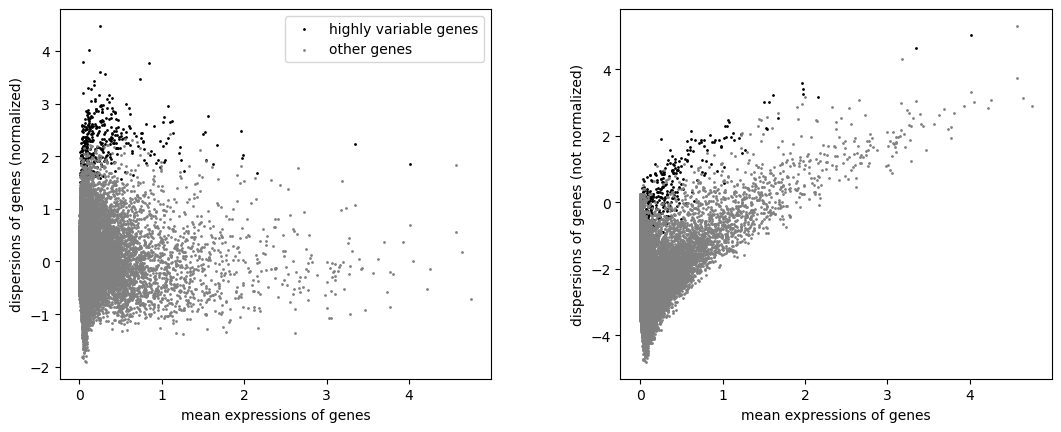

In [43]:
# Construct the anndata object containing all the datasets
adata = construct_ad(filtered_datasets)

# Pre-process the data
adata_no_batch = preprocess(adata, False, 400)


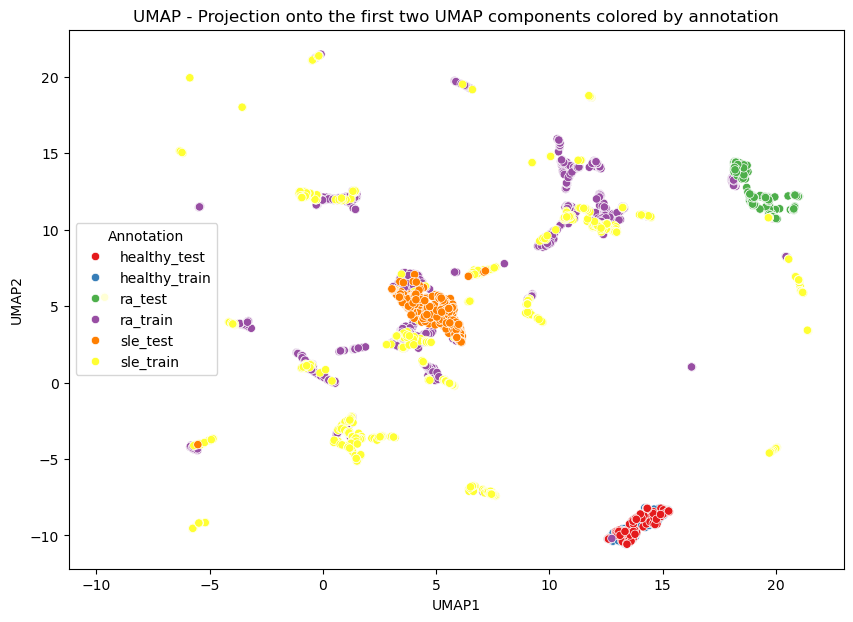

In [44]:
# Load the transcription dataset
X = adata_no_batch.X
y = adata_no_batch.obs['batch']

# Dimensionality reduction with UMAP
reducer = umap.UMAP(n_components=2)
X_umap = reducer.fit_transform(X)

# Convert the UMAP result to a DataFrame for easier data manipulation
df_umap = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])
df_umap['Label'] = y.values  # Ensure y is correctly assigned

# Scatter plot of the first two UMAP components colored by annotation
plt.figure(figsize=(10, 7))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='Label', palette='Set1', data=df_umap)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP - Projection onto the first two UMAP components colored by annotation')
plt.legend(title='Annotation')
plt.show()

In [27]:
adata_no_batch.write_h5ad("/home/mc202900/outputs/Dataset_PP_400")